#Reinforcement Learning Project-1






###A. Environment

The following is a gridworld environment. It depicts a 'Parking Lot' where the agent (yellow square) represents a car that needs to move from the initial state (0, 0) to the parking spot (4, 4) in blue. On the way there are 3 penalty states, (3, 2) , (4, 0) and (1, 3) which represent wet concrete which the car (agent) needs to avoid. The environment can be used in both deterministic mode as well as stochastic mode.

The environment is an MDP ( Markov Decision Process) represented by the following Tuple: 
####<S, A, P, R, $\gamma $> 
where,

S is a set of states such s $\epsilon$ {each cell in the grid world}


A is a set of actions such that a $\epsilon$ [0, 1 , 2, 3] corrsponding to ['Up', 'Right' , 'Left', 'Down']

P is a transition probaility matrix given by:
  

*   $P_{ss'} = P[S_{t+1} = s' | S_{t} = s, A_{t} = a] \epsilon[0, 1]$ when the environment is deterministic 
*   $P_{ss'} = \sum{P[S_{t+1} = s' | S_{t} = s, A_{t} = a]} \epsilon=1$ when the environment is stochastic 

R is the reward the which the agent receives on visiting each state $S_{t+1}$ from state $S_{t}$ after taking action A given by $R_{s} = E[R_{t+1}| S_{t} = s, A_{t} = a]$

$\gamma$ is the discount factor $\epsilon$ [0, 1)

>The agent receives a reward of -1 each time it lands in a state, except the 3 Penalty states where it gets a rewards of -5 and the Terminal state where it receives a reward of 0. The goal of the agent is to reach the Terminal state maximizing it's cumulative reward.



In [0]:
import gym
import numpy as np
import pandas as pd
from gym import error, spaces, utils
from gym.utils import colorize, seeding
import matplotlib.pyplot as plt
from time import sleep
from google.colab import widgets
import random
from collections import defaultdict
from IPython.display import clear_output
import pprint

class ParkinglotEnv():

    metadata = {"render.modes": ["human"]}


    def __init__(self, deterministic = True):

        # Define an A 5X5 Matrix to represent the grid environment 
        self.grid = np.zeros((5, 5))
        self.nrows, self.ncols = self.grid.shape
        self.deterministic = deterministic
        
        #Initial position of the agent
        self.grid[0, 0] = 1

        #Define state space(Excluding the Terminal state) 
        self.state_space = spaces.Discrete(25)
        
        #State Space Plus(State Space with all the states)
        self.state_space_plus = spaces.Discrete(26)

        #Define Action Space
        self.action_space = spaces.Discrete(4)

        #Define Actions
        #The Actions are represented as numeric values. They have the following mapping:
        """
            Actions:
            [
              0 --> Up
              1 --> Right
              2 --> Down 
              3 --> Left
            ]
        
        """

        #Defining how agent's position is updated when an action is chosen
        self.actions = {0: -self.nrows, 1: 1, 2: self.nrows, 3: -1}
        self.current_position = 1
        
        #Set the position of the Terminal State to bottom right 
        self.terminal_state = self.nrows * self.ncols - 1
        self.grid[self.nrows - 1, self.ncols - 1] = 0.3
        self.done = False

        #Set penalty positions that the agent must avoid
        self.penalty_positions = [20, 8, 17]
        for each in self.penalty_positions:
          x, y = self.getAgentPosition(each)
          self.grid[x, y] = 0.65 #assigning a reward of -5

        self.timestep = 0
        #define max time step after which the episode terminates if the agent 
        #hasn't reached terminal state yet
        self.max_timestep = 12

    #Return indices of the agent's position in the grid matrix
    def getAgentPosition(self, pos):
        x = pos // self.nrows
        y = pos % self.ncols
        return x, y

    #Make sure the agent transitions to a valid state
    def is_valid_state(self, action, new_position):
        if new_position not in self.state_space:
            return False
        elif action == 0 or action == 2:
            return self.current_position % self.ncols == new_position % self.ncols
        else:
            return self.current_position // self.nrows == new_position // self.nrows

    #Returns the new state of the agent. This function checks whether the environment is deterministic or stochastic.
    def getNewPosition(self, agent_pos, action):
        new_position = agent_pos + self.actions[action]
        if self.is_valid_state(action, new_position):
          if not self.deterministic:
            return np.random.choice([new_position, agent_pos], p=[0.9, 0.1])
          return new_position
        return agent_pos


    def step(self, action):
        agent_pos = self.current_position
        x, y = self.getAgentPosition(agent_pos)
        new_pos = self.getNewPosition(agent_pos, action)
        if agent_pos in self.penalty_positions:
          self.grid[x, y] = 0.65
        else:
          self.grid[x, y] = 0
        x, y = self.getAgentPosition(new_pos)
        self.grid[x, y] = 1
        self.current_position = new_pos
        reward = -1
        self.timestep += 1
        #teminate episode of max_timestep is reached
        if self.timestep >= self.max_timestep:
          self.done = True
        elif new_pos == self.terminal_state:
            self.done = True
            reward = 0
        if new_pos in self.penalty_positions:
          reward = -5
        return self.current_position, reward, self.done, 0

    def reset(self):
        self.grid = np.zeros((5, 5))
        self.grid[0][0] = 1
        self.grid[self.nrows-1, self.ncols-1] = 0.3
        for each in self.penalty_positions:
          x, y = self.getAgentPosition(each)
          self.grid[x, y] = 0.65 
        self.current_position = 0
        self.timestep = 0
        self.done = False
        return self.current_position

    def render(self, mode='human', close=False):
        output_grid = widgets.Grid(1,1)  
        with output_grid.output_to(0,0):
          clear_output(wait=True)
          plt.imshow(self.grid)
        sleep(1)




The example below shows the environment implemented in the deterministic mode using a random agent that moves 'Right' or 'Down'. Each transition has the same probability of reaching a new state given starting state and action.

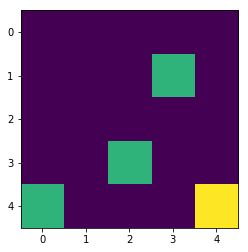

<IPython.core.display.Javascript object>

Total Reward:-9


In [22]:
env = ParkinglotEnv()
env.reset()
env.render()
done = False
reward = []
while not done:
  res = env.step(np.random.choice([1,2]))
  reward.append(res[1])
  done = res[2]
  env.render()
print("Total Reward:"+str(np.sum(reward)))

The following is an example of a stochastic environment where the agent has a probability of 0.9 of moving to a new state given an initial state and an action, and a 0.1 probability of remaining in it's current state.

>Note: If the agent is along the edges and attemptes to move out of the grid, the action returns it to the same state. This is true for the environment in both deterministic and stochastic modes. A way of identifying the stochasticity of the environment is when the agent is in one of the middle positions and remains in the same position after an action is taken.


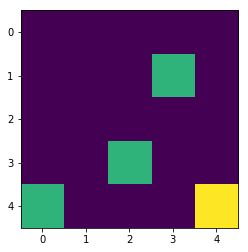

<IPython.core.display.Javascript object>

Total Reward:-9


In [23]:
env = ParkinglotEnv(False) # Setting the flag deterministic = false
env.reset()
env.render()
done = False
reward = []
while not done:
  res = env.step(np.random.choice([1,2]))
  reward.append(res[1])
  done = res[2]
  env.render()
print("Total Reward:"+str(np.sum(reward)))

### B. Agent

The given agent implements an _off-policy $\epsilon$-greedy Q- Learning_ algorithm to converge to an optimal behaviour. Q-learning is an off-policy TD-control algorithm which implements a tablular approach where the learned action-value function Q, directly estimates the optimal Action-value function independent of the policy. It uses the following formula to estimate the optimal Q value,
> $Q(S, A) <--    Q(S, A) + \alpha[R + \gamma max_{a}Q(S', a) - Q(S, A)]$
Where,



R is the immediate reward of transition


Q(S,A) is the predicted value

Q(S', a) is the value of taking aciton a and transition to the         new state,

[R + $\gamma max_{a}$Q(S', a) is the target value,

$\alpha$ is the learning rate,

$\gamma$ is the discount factor rate

The agent performs the above operation every episode for each step and updates the Q-table till it arrives at an optimal State-value function. The Q-table is then used as the policy.

In [0]:
class Agent():

  metadata = {"render.modes": ["human"]}
  

  def __init__(self, alpha=0.6, gamma=0.8, epsilon=0.4):

    #define a Q table with states along the row and actions as column. Initialize all the values to 0
    self.Q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    self.alpha=alpha # learning rate of the agent
    self.gamma=gamma # discount factor for future rewards
    self.epsilon=epsilon 


  # the agent chooses the greedy action with 1- epsilon probability and a random action with epsilon probability
  def choose_next_action(self, env, state):

    all_action_probabilities = np.ones(env.action_space.n)*self.epsilon/env.action_space.n
    best_action = np.argmax(self.Q_table[state])
    all_action_probabilities[best_action]+=(1.0 - self.epsilon)
    return np.random.choice(env.action_space.n, p=all_action_probabilities)

  #Q-Learning algorithm
  def qlearning(self, env, episodes, suppress_render = False):

    for iteration in range(episodes):
      
      done = False
      state = env.reset()
      
      while not done:
        action = self.choose_next_action(env, state)
        next_state, reward, done, info = env.step(action)

        prev_q_value = self.Q_table[state][action]
        next_state_max_value = np.max(self.Q_table[next_state])

        target = reward + self.gamma*next_state_max_value
        loss = self.alpha* (target - prev_q_value)
        self.Q_table[state][action]  += loss

        state = next_state
      #Show the Q-table at the end of training
    if not suppress_render:    
      print("Q-Table")
      print("------------")
      print(pd.DataFrame([self.Q_table[X] for X in range(25)], columns = ['Up', 'Right','Down', 'Left']))
      print("Training completed!")

  #Agent traverses the environment using the Q-Table to find the optimal action to take at each state
  def traverse(self, env, suppress_render = False):
    state = env.reset()
    done = False
    return_ = 0
    if not suppress_render:
      env.render()
    state_direction=np.zeros(env.state_space_plus.n)
    while not done:
      next_action = np.argmax(self.Q_table[state])
      state_direction[state] = next_action
      next_state, reward, done, info = env.step(next_action)
      return_+=reward
      state = next_state
      if not suppress_render:
        env.render()
    if not suppress_render:
      print("Total Return = "+str(return_))
    return return_


###Training the agent in the environment in deterministic mode

In [25]:
env = ParkinglotEnv()
agent = Agent()
agent.qlearning(env, 300) #training the agent using 300 iterations

Q-Table
------------
          Up     Right      Down      Left
0  -4.184857 -4.018590 -4.012252 -4.185223
1  -4.011704 -3.765424 -3.778169 -4.170450
2  -3.755848 -3.482114 -3.484844 -4.008455
3  -3.439266 -3.105465 -7.004269 -3.737846
4  -2.962459 -2.996919 -2.623152 -3.437684
5  -4.203679 -3.770548 -3.774233 -3.995236
6  -3.994774 -3.478940 -3.477710 -3.997305
7  -3.747686 -7.010018 -3.145019 -3.757329
8  -3.300549 -2.669377 -2.590772 -3.442856
9  -2.966122 -2.540263 -2.036450 -7.043210
10 -4.000461 -3.472589 -3.510341 -3.754737
11 -3.769212 -3.105585 -3.104430 -3.733915
12 -3.499813 -2.686343 -6.597154 -3.464226
13 -7.058551 -2.126351 -2.138727 -3.106993
14 -2.536901 -2.040356 -1.221549 -2.498048
15 -3.703359 -3.076863 -7.100231 -3.490133
16 -3.437603 -6.558286 -2.592135 -3.408617
17 -2.636426 -1.998495 -2.012518 -3.006612
18 -2.605711 -1.403086 -1.465691 -6.431168
19 -2.048012 -1.176160 -0.256748 -1.975318
20 -3.450027 -2.473494 -3.000000 -3.000000
21 -2.992213 -2.030829 -2.458483 

#### Checking the performance of the agent after 300 iterations

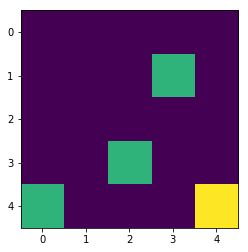

<IPython.core.display.Javascript object>

Total Return = -7


-7

In [26]:
agent.traverse(env) # please run the code in the cell above first to train the agent

We plot the reward at the end of each episode vs the number of iterations for a deterministic environment. 

>_Inference_: We see that after a particular number of iterations, the agent has converged to an optimal state-value function Q after which it traverses the environment to get the maximum reward each time.

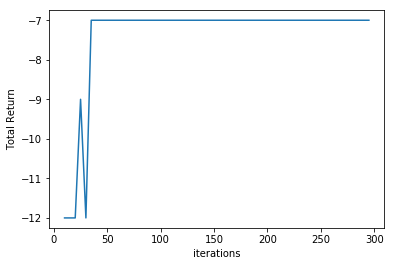

In [27]:
result_arr = []
env = ParkinglotEnv()
agent = Agent(alpha=0.6, gamma=0.8, epsilon=0.4)
for iter in range(10, 300, 5): # starting from 10 iterations in steps of 5 till 300
  agent.qlearning(env, iter, True)
  result_arr.append(agent.traverse(env, True))
plt.plot(range(10, 300, 5), result_arr)
plt.xlabel('iterations')
plt.ylabel('Total Return')
plt.show()

###Training the agent in the environment in stochastic mode

In [28]:
env = ParkinglotEnv(False)
agent = Agent()
agent.qlearning(env, 300) #training the agent using 300 iterations

Q-Table
------------
          Up     Right      Down      Left
0  -4.276079 -4.097908 -4.167120 -4.260479
1  -4.073956 -3.881068 -3.959024 -4.260825
2  -3.848360 -3.745571 -3.580378 -4.077464
3  -3.527268 -3.143138 -6.984062 -3.797131
4  -3.133227 -3.187328 -2.666809 -3.479653
5  -4.260759 -3.918476 -3.906951 -4.032300
6  -4.091671 -3.769714 -3.623698 -4.048293
7  -3.853777 -7.378885 -3.210251 -3.878626
8  -3.928664 -2.647809 -4.579186 -3.560489
9  -3.088031 -2.708136 -2.102054 -7.404156
10 -4.108113 -3.836756 -3.574665 -3.885304
11 -3.801258 -3.261231 -3.183153 -3.797759
12 -3.566561 -3.020672 -4.590793 -3.561235
13 -4.465584 -2.273152 -2.327531 -3.186873
14 -2.672313 -1.947005 -1.698641 -2.599932
15 -3.783515 -3.114578 -4.996195 -3.511139
16 -3.571542 -6.565610 -2.679803 -3.614732
17 -3.001264 -2.166329 -1.961169 -3.196637
18 -2.304676 -1.446409 -1.360422 -5.874786
19 -1.800852 -1.220615 -0.365389 -2.203074
20 -3.520013 -3.927069 -5.775921 -5.640000
21 -3.235014 -2.129080 -2.855181 

#### Checking the performance of the agent after 300 iterations

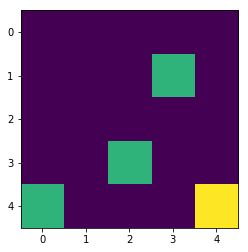

<IPython.core.display.Javascript object>

Total Return = -7


-7

In [29]:
agent.traverse(env)

Although the reward is lesser than it's optimal value due to the stochastic nature of the environment, the agent still chooses the best path to the Terminal state.

We plot the reward at the end of each episode vs the number of iterations for a stochastic environment. 

>_Inference_: We see that after a particular number of iterations, the agent has converged to an optimal state-value function Q after which it traverses the environment to get the maximum reward each time.

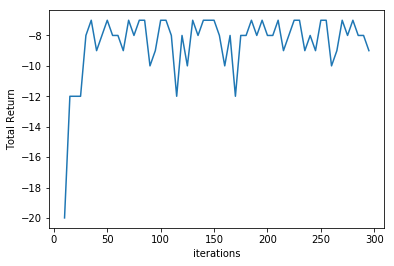

In [30]:
result_arr = []
env = ParkinglotEnv(False)
agent = Agent(alpha=0.6, gamma=0.8, epsilon=0.4)
for iter in range(10, 300, 5): # starting from 10 iterations in steps of 5 till 300
  agent.qlearning(env, iter, True)
  result_arr.append(agent.traverse(env, True))
plt.plot(range(10, 300, 5), result_arr)
plt.xlabel('iterations')
plt.ylabel('Total Return')
plt.show()

We see that the fluctuations are too drastic but stabilize after a point. 
Though this is due to the stochasticity of the environment,as the number of training iterations increase, it's performance is improved.
